# Oseen Wake

This notebook deals with the Oseen wake that is responsible for the lifting force and back flipping of air bubbles. The flow field can be expressed in spherical coordinates as follows:

$$
\frac{u_r}{U} = -\frac{a^3 \cos \theta}{2r^3} + \frac{3a^2}{2r^2 Re} \left\{ 1 - \exp\left[ -\frac{rRe}{2a} (1 + \cos\theta) \right] \right\} \\- \frac{3a(1-\cos\theta)}{4r} \exp\left[ -\frac{rRe}{2a} (1 + \cos\theta) \right] 
$$

$$
\frac{u_\theta}{U} = -\frac{a^3\sin\theta}{4r^3} - \frac{3a\sin\theta}{4r}\exp\left[ -\frac{rRe}{2a} (1+\cos\theta) \right]
$$

$$
\frac{u_\varphi}{U} = 0
$$

Since the bubble simulation is formulated in Cartesian coordinates, we convert the above to $u_x$, $u_y$ and $u_z$ using:

$$
u_x = u_r \sin\theta\cos\phi + u_\theta \cos\theta\cos\phi - u_\phi\sin\phi
$$

$$
u_y = u_r \sin\theta\sin\phi + u_\theta \cos\theta\sin\phi + u_\phi\cos\phi
$$

$$
u_z = u_r \cos\theta - u_\theta\sin\theta
$$

where 

$$
\sin\theta = \frac{\sqrt{x^2 + y^2}}{r}
$$

$$
\cos\theta = \frac{z}{r}
$$

$$
\sin\phi = \frac{y}{\sqrt{x^2 + y^2}}
$$

$$
\cos\phi = \frac{x}{\sqrt{x^2 + y^2}}
$$

and 

$$
r = \sqrt{x^2 + y^2 + z^2}
$$

## 0 Packages

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import healpy as hp
pv.set_jupyter_backend("html")

## 1 Velocity field in Cartesian coordinates

### 1.1 Put the equations in code

In [34]:
# define constants
U = 1.0e-4
mu = 1.0e-3
rho = 1.0e3
a = .3
Re = rho * a * U / mu

In [35]:
# define mesh
lim = 2
res = 20
x = np.linspace(-lim, lim, res)
y = np.linspace(-lim, lim, res)
z = np.linspace(-lim, lim, res)
x, y, z = np.meshgrid(x, y, z)

x = x.flatten()
y = y.flatten()
z = z.flatten()

In [36]:
# compute variables in spherical coordinates
r = x**2 + y**2 + z**2
sint = (x**2 + y**2)**0.5 / r
cost = z / r
sinp = y / (x**2 + y**2)**0.5
cosp = x / (x**2 + y**2)**0.5

In [37]:
valid_ind = r > a

In [38]:
# velocity field in spherical coordinates
u_r = U * ( 
    - a**3 * cost / 2 / r**3 
    + 3 * a**2 / 2 * r**2 * Re * (
        1 - np.exp(- r * Re / 2 / a * (1 + cost))
    )
    - 3 * a * (1 - cost) / 4 / r * np.exp(- r * Re / 2 / a * (1 + cost))
)
u_t = U * (
    - a**3 * sint / 4 / r**3 
    - 3 * a * sint / 4 / r * np.exp(- r * Re / 2 / a * (1 + cost))
)
u_p = 0

In [39]:
# convert spherical coordinates velocity to Cartesian
# up to here, we have u(x, y, z) 
u_x = u_r * sint * cosp + u_t * cost * cosp - u_p * sinp
u_y = u_r * sint * sinp + u_t * cost * sinp + u_p * cosp
u_z = u_r * cost - u_t * sint

In [40]:
for i in [x, y, z, u_x, u_y, u_z]:
    i[~valid_ind] = np.nan

In [44]:
points = np.stack([x, y, z], axis=-1)
velocity = np.stack([u_x, u_y, u_z], axis=-1)
ones = np.ones(velocity.shape[0])

pl = pv.Plotter()
grid = pv.PolyData(points)
grid["v"] = velocity
grid["v_mag"] = np.linalg.norm(velocity, axis=1)
grid["ones"] = ones
pl.add_mesh(grid)
glyphs = grid.glyph(orient="v", scale="v_mag", factor=.5)
pl.add_mesh(glyphs)
pl.show_axes()
pl.camera_position = "yz" 
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

### 1.2 Implement a class for the ease of use

In the simulation, we can initiate a `OseenWake` class with

```
oseen = OseenWake(U, a)
```

Then, at each step, we can use the instance to calculate the flow velocity at a collection of points:

```
flow = oseen.flow(points)
```

where `points` are np.array of shape [npts, 3].

In [ ]:
class Sphere:
    """Compute the flow field in a Oseen wake. The flow field is characterized by two regions: a Stokeslet in the low Reynolds region and a compensating flow """
    def __init__(self, a, U=0, rho=1e3, mu=1e-3):
        self.a = a # bubble radius
        self.U = U # upward velocity (only upward!)
        self.rho = rho # density
        self.mu = mu # viscosity
        self.pos = np.array([0, 0, 0]) # bubble position
        self.surf_coords, self.unit_normals, self.ds = self._compute_surface_coords()

    def Oseen_wake(self, points):
        """Compute Oseen wake at given points. 

        Args:
        points -- should be an array of (npts, 3).

        Returns: 
        flow -- the flow velocity at each given point, also (npts, 3).
        """
        U = self.U
        a = self.a
        rho = self.rho
        mu = self.mu
        Re = rho * a * U / mu

        x, y, z = points[:, 0], points[:, 1], points[:, 2]
        r = x**2 + y**2 + z**2
        sint = (x**2 + y**2)**0.5 / r
        cost = z / r
        sinp = y / (x**2 + y**2)**0.5
        cosp = x / (x**2 + y**2)**0.5

        u_r = U * ( 
            - a**3 * cost / 2 / r**3 
            + 3 * a**2 / 2 * r**2 * Re * (
                1 - np.exp(- r * Re / 2 / a * (1 + cost))
            )
            - 3 * a * (1 - cost) / 4 / r * np.exp(- r * Re / 2 / a * (1 + cost))
        )
        u_t = U * (
            - a**3 * sint / 4 / r**3 
            - 3 * a * sint / 4 / r * np.exp(- r * Re / 2 / a * (1 + cost))
        )
        u_p = 0

        u_x = u_r * sint * cosp + u_t * cost * cosp - u_p * sinp
        u_y = u_r * sint * sinp + u_t * cost * sinp + u_p * cosp
        u_z = u_r * cost - u_t * sint

        # The velocity diverges at r=0, implying that this velocity should be considered as "far field" velocity
        # thus, we mask out all the velocities inside the imaginary shpere, where r <= a
        invalid = r <= a
        u_x[invalid] = 0
        u_y[invalid] = 0
        u_z[invalid] = 0

        return np.stack([u_x, u_y, u_z], axis=-1)
    
    def get_pos(self):
        return self.pos
    
    def set_pos(self, pos):
        self.pos = np.array(pos)

    def _compute_surface_coords(self, nside=4):
        """Compute the coordinates of the surface differential area and surface unit normal vectors.
        
        Args:
        nside -- controls how many parts the spherical surface is to be divided, utilizing the `healpy` package. Has to be power of 2. The number of parts will be 12*nside**2.
        
        Returns:
        surface_coords -- coordinates of surface differential area __relative to the center__ of the sphere.
        unit_normals -- unit normal vectors corresponding to the surface locations.
        differential_surface_area -- the area of each differential surface unit."""

        R = self.a
        npix = hp.nside2npix(nside)

        # Get spherical coordinates (theta, phi) of each pixel center
        theta, phi = hp.pix2ang(nside, np.arange(npix))

        x = R * np.sin(theta) * np.cos(phi) 
        y = R * np.sin(theta) * np.sin(phi) 
        z = R * np.cos(theta)
        surface_coords = np.stack([x, y, z], axis=-1)
        unit_normals = surface_coords / np.linalg.norm(surface_coords, axis=-1, keepdims=True)
        differential_surface_area = 4 * np.pi * R**2 / npix
        return surface_coords, unit_normals, differential_surface_area

In [64]:
U = 1.0e-4
a = .2
im = Sphere(a, U=U) # the imaginary bubble instance
re = Sphere(a) # the real bubble instance
re.set_pos([.5, 0, -.5]) # set real bubble to be away from the imaginary bubble

In [65]:
# check the surface coordinates calculation
grid = pv.PolyData(re.surf_coords)
pl = pv.Plotter(window_size=(400, 400))
grid["normal"] = re.unit_normals
glyph = grid.glyph(orient="normal", scale="normal", factor=.05)
pl.add_mesh(grid)
pl.add_mesh(glyph)
pl.show()
# grid.plot()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [66]:
# Check the flow around the bubble
rel_pos = re.surf_coords - re.pos - im.pos # calculated the relative position between the surface of real sphere and the center of the imaginary sphere
flow = im.Oseen_wake(rel_pos)

In [ ]:
# do multiple spheres around a imaginary sphere that generates Oseen Wake
locs = [(0, 0, -0.5), (0.5, 0, -0.5), (1, 0, -0.5),
        (0, 0, -1  ), (0.5, 0, -1.0), (1, 0, -1),
        (0.5, 0, 0) , (1.0, 0, 0)]
spheres = []
for loc in locs:
    s = Sphere(a)
    s.set_pos(loc)
    spheres.append(s)

In [93]:
# direction of the flow
pl = pv.Plotter()
mesh = pv.Sphere(radius=im.a, center=im.pos)
pl.add_mesh(mesh, opacity=0.3)
for re in spheres:
    rel_pos = re.surf_coords + re.pos - im.pos
    flow = im.Oseen_wake(rel_pos)
    grid = pv.PolyData(re.pos + re.surf_coords)
    mesh = pv.Sphere(radius=re.a, center=re.pos)
    grid["flow"] = flow
    grid["normal"] = np.linalg.norm(re.unit_normals, axis=1)
    glyph = grid.glyph(orient="flow", scale="normal", factor=.1)
    pl.add_mesh(mesh)
    pl.add_mesh(glyph, clim=[1, 1], scalar_bar_args={"title": "Z", "n_labels": 5, "fmt": "%.2f"})
pl.add_axes()
pl.camera_position = "xz"
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [101]:
pl = pv.Plotter()
mesh = pv.Sphere(radius=im.a, center=im.pos)
pl.add_mesh(mesh, opacity=0.3)
for re in spheres:
    rel_pos = re.surf_coords + re.pos - im.pos
    flow = im.Oseen_wake(rel_pos)
    # clip the velocity data
    max_mag = 0.001
    # Normalize and rescale any vector > max_mag
    mag = np.linalg.norm(flow, axis=1)
    scale = np.minimum(1.0, max_mag / (mag + 1e-12))  # Avoid divide-by-zero
    flow_clipped = flow * scale[:, np.newaxis]

    grid = pv.PolyData(re.pos + re.surf_coords)
    mesh = pv.Sphere(radius=re.a, center=re.pos)
    grid["flow"] = flow_clipped
    grid["normal"] = np.linalg.norm(re.unit_normals, axis=1)
    glyph = grid.glyph(orient="flow", scale="flow", factor=200)
    pl.add_mesh(mesh)
    pl.add_mesh(glyph)
pl.add_axes()
pl.camera_position = "xz"
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## 2 Velocity on a spherical shell

In the simulation, we want to compute the velocity (i.e. the shear force) acting on the whole bubble surface and integrate the effect. In this section, we implement this calculation by

1. Identifying surface locations and normals (done in Sphere class);
2. Getting flow field at each location (done in Sphere class);
3. Computing tangential projections;
4. Integrating over the surface.

We consider two bubbles, one imaginary and one real, as sketched below. The imaginary bubble generates and Oseen wake, which drives the rotation and translation of the real bubble. 

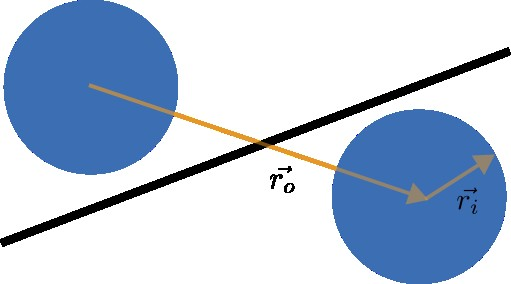

We calculate the average circulation $\bar\Gamma$ as

$$
\bar\Gamma = \frac{1}{2a} \int_S u_s \; dS,
$$

where $a$ is the radius of bubble and $u_s$ is the projection of velocity on the spherical surface. Furthermore, since we only consider vorticity in the $xz$ plane, we also project the velocity in the $xz$ plane. 

Then, we calculate an approximated local vorticity as

$$
\bar\omega \approx \frac{1}{\pi a^2} \bar\Gamma.
$$

The lift force $F_l$ points to the left if the circulation is CW, and has the form

$$
F_l = C_l \mathbf{\bar\omega} \times \mathbf{v} 
$$

where $C_l$ is the lift coefficient, and $\mathbf{v}$ is the negative velocity of the bubble. 